Nama : Aaz Muhammad Hafidz Azis


NIM : 23521085


---



**Readme**

*Jika terjadi error ketika training dengan massage berikut* 

***Input 'y' of 'Sub' Op has type float32 that does not match type uint8 of argument 'x'***

*maka, import dan load kembali dataset yang digunakan lalu langsung run kembali code yang mau di training* 

Import Library 

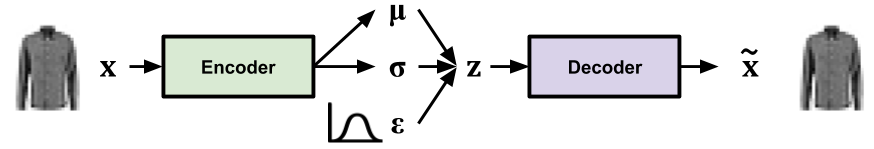

In [153]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose
%tensorflow_version 2.x
%matplotlib inline

import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to suppress tensorflow warnings


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load and Process the Dataset

Dataset diambil dari Website Keras yang berisi data gambar fashion dengan jumlah data train 6000, data test 10000 berikut dengan labelnya. 

In [268]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [269]:
print(X_train.shape, '\t', y_train.shape)
print(X_test.shape, '\t', y_test.shape)

(60000, 28, 28) 	 (60000,)
(10000, 28, 28) 	 (10000,)


Pada dataset Fashion Mnist ini memiliki 10 label dengan deksripsi sebagai berikut 

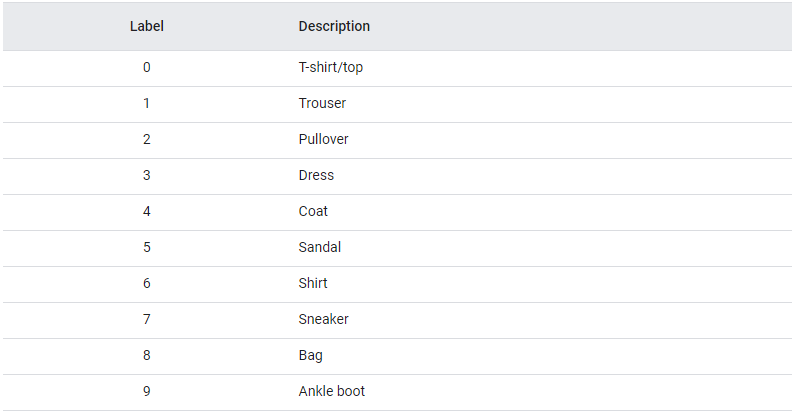

Contoh code di bawah ini menampilkan 10 sampel dari label data pada data train dan test

In [270]:
print('\t',y_train[:10],'\n\t',y_test[:10])

	 [9 0 0 3 0 2 7 2 5 5] 
	 [9 2 1 1 6 1 4 6 5 7]


kemudian, dilakukan normalisasi terhadap data dengan nilai antara 0 sampai 255

In [271]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Fungsi .reshape() digunakan untuk membentuk ulang data yang akan digunakan dalam format lapisan TensorFlow yaitu, (number of samples, width, height, number of channels)

In [272]:
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

In [273]:
print(X_train.shape, '\t', X_test.shape)

(60000, 28, 28, 1) 	 (10000, 28, 28, 1)


## Visualization of Samples

melakukan visualisasi beberapa sampel dari data

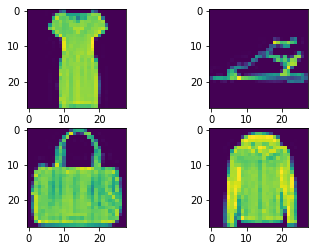

In [186]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[20][:,:,0])

plt.subplot(222)
plt.imshow(X_train[300][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4000][:,:,0])

plt.subplot(224)
plt.imshow(X_train[5000][:,:,0])
plt.show()

## Model Architecture

melakukan perancangan model VAE yang terdiri dari encoder, latent space dan decoder.

### Encoder

In [187]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = K.int_shape(x)

In [188]:
x = Flatten()(x)
x = Dense(32)(x)

Laten Space

In [189]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

Fungsi di bawah ini akan  mengambil parameter mean dan log varians dan mengembalikan sampel acak dari distribusi yang dihasilkan.

In [190]:
def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps
  return rnd_sam

 kode di bawah ini merupakan layer untuk memperoleh nilai Latent Space (z) dengan menggunakan Lambda Expression. 

In [191]:
z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

### Model Summary

Dari Beberapa Fungsi di atas, Summary yang diperoleh, ditampilkan pada visualisasi di bawah ini

In [192]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 28, 28, 128)  3328        ['encoder input[0][0]']          
                                                                                                  
 conv2d_37 (Conv2D)             (None, 14, 14, 64)   73792       ['conv2d_36[0][0]']              
                                                                                                  
 conv2d_38 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_37[0][0]']              
                                                                                            

### Decoder

pada bagian ini,  kita perlu mengambil vektor dari ruang laten 2D sampel acak dan mengubahnya kembali ke format asli gambar yaitu, 28x28 dengan *single channel*

In [193]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_18 (Dense)            (None, 12544)             37632     
                                                                 
 reshape_8 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_41 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 28, 28, 64)       3692

## Menghubungkan Semua Komponen

Menghubungkan Encoder, Latent Space dan Decoder 

In [194]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)

vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 552548    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         356545    
                                                                 
Total params: 909,093
Trainable params: 909,093
Non-trainable params: 0
_________________________________________________________________


## Fungsi-fungsi yang diperlukan

First, we need to define a custom loss function which trains our model based to improve an error defined as the sum of reconstruction loss and KL-Divergence loss.

In [169]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

melakukan visualisasi rekonstruksi dari sebelum dan sesudah di rekonstruksi

In [170]:
def visualisasi_rekonstruksi(index):
  y_pred = vae.predict(X_test)

  plt.figure(1)
  plt.subplot(221)
  plt.imshow(X_test[index].reshape(28,28))

  plt.subplot(222)
  plt.imshow(y_pred[index].reshape(28,28))

  plt.subplot(223)
  plt.imshow(X_test[index*5].reshape(28,28))

  plt.subplot(224)
  plt.imshow(y_pred[index*5].reshape(28,28))
  plt.show()

Melakukan visualisasi terhadap latent Space yang terbentuk dari model

In [171]:
def visualize_latent_space(load_model, n_parameter):
  tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

  decoder = keras.models.load_model(load_model, compile=False)

  #Set the parameters of the plot
  n = n_parameter #20x20 grid
  figure = np.zeros((28 * n, 28 * n, 1))
  #Set the limits of the area to be explored within our latent space
  grid_x = np.linspace(1, 3, n)
  grid_y = np.linspace(0, 2, n)[::-1]

  #Decode an image for each vector
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded.reshape((28,28,1))
          figure[i*28:(i+1)*28, j*28:(j+1)*28] = digit


  #Plotting
  plt.figure(figsize=(10, 10))
  fig_shape = np.shape(figure)
  figure = figure.reshape((fig_shape[0], fig_shape[1]))
  plt.imshow(figure, cmap='PiYG')
  plt.show()  

## Training 2 Dimensi Latent Space

### Training Model 1 Epoch 20 

In [172]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
1875/1875 [==============================] - 25s 13ms/step - loss: 8.5737 - val_loss: 7.6467
Epoch 2/20
1875/1875 [==============================] - 27s 14ms/step - loss: 7.5371 - val_loss: 7.4160
Epoch 3/20
1875/1875 [==============================] - 25s 13ms/step - loss: 7.4062 - val_loss: 7.3365
Epoch 4/20
1875/1875 [==============================] - 25s 13ms/step - loss: 7.3382 - val_loss: 7.2928
Epoch 5/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.2963 - val_loss: 7.3316
Epoch 6/20
1875/1875 [==============================] - 25s 14ms/step - loss: 7.2548 - val_loss: 7.2813
Epoch 7/20
1875/1875 [==============================] - 25s 13ms/step - loss: 7.2256 - val_loss: 7.2356
Epoch 8/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.1934 - val_loss: 7.1737
Epoch 9/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.1715 - val_loss: 7.1586
Epoch 10/20
1875/1875 [==============================] - 25s 14m

313/313 [==============================] - 2s 5ms/step


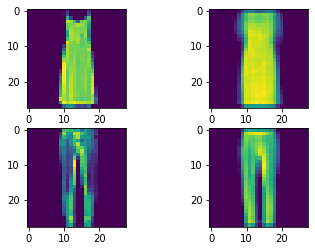

In [173]:
# index = int(input())
visualisasi_rekonstruksi(13)

In [174]:
keras.models.save_model(encoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_1_E20_Encoder.h5')
keras.models.save_model(decoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_1_E20_Decoder.h5')
keras.models.save_model(vae, '/content/drive/MyDrive/Variational Auto Encoder/Model_1_E20_VAE.h5')

1/1 [==============================] - 0s 121ms/step


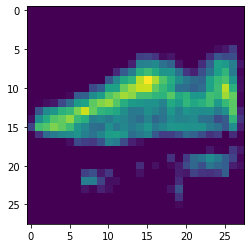

In [175]:
sample_vector = np.array([[90,24]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))

1875/1875 [==============================] - 4s 2ms/step
[[ 1465.0193   3697.9907 ]
 [-3602.908     375.0131 ]
 [-1309.005    -539.1521 ]
 ...
 [-3036.3926   -591.10156]
 [-1293.9025    237.10146]
 [  493.22076   583.54095]]


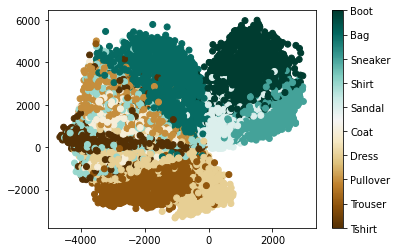

In [176]:
tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
labels = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
latent_dim=2

encoder = keras.models.load_model('/content/drive/MyDrive/Variational Auto Encoder/Model_1_E20_Encoder.h5', custom_objects={'latent_dim': latent_dim})
z = encoder.predict(X_train)
print(z)

fig = plt.scatter(z[:,0], z[:,1], c=y_train, cmap='BrBG')
cbar = plt.colorbar(fig)
cbar.set_ticks(list(range(0,10)))
cbar.set_ticklabels(labels)
plt.show()

1/1 [==============================] - 0s 23ms/step


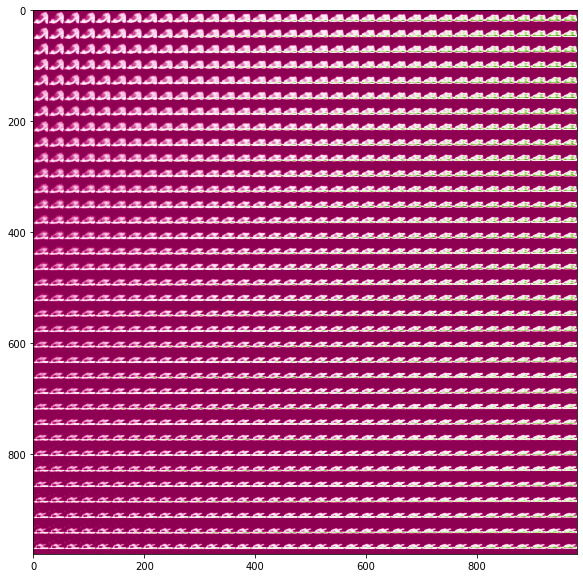

In [177]:
visualize_latent_space('/content/drive/MyDrive/Variational Auto Encoder/Model_1_E20_Decoder.h5', 35)

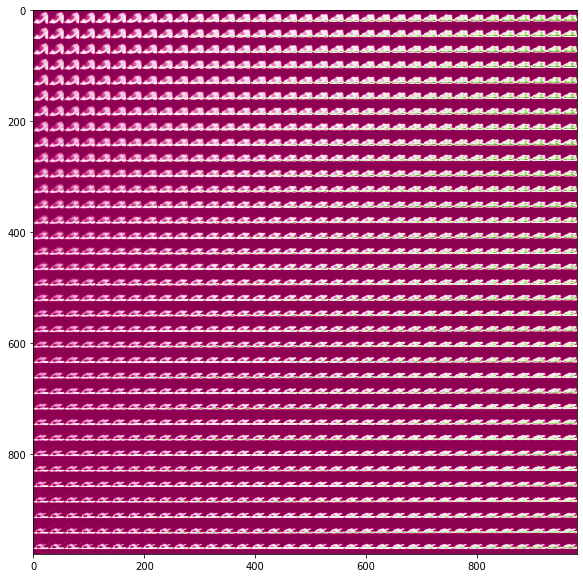

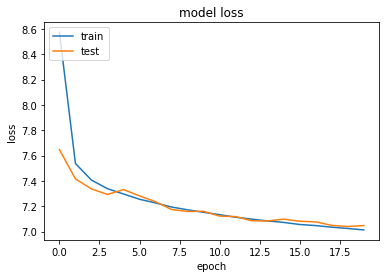

In [290]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Training Model 2 Epoch 40

In [195]:
vae_2 = keras.Model(enc_input, dec_output, name='VAE_2_E40')
vae_2.summary()

Model: "VAE_2_E40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 552548    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         356545    
                                                                 
Total params: 909,093
Trainable params: 909,093
Non-trainable params: 0
_________________________________________________________________


In [196]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae_2.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))
history_2 = vae_2.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/40
1875/1875 [==============================] - 26s 14ms/step - loss: 8.3404 - val_loss: 7.6364
Epoch 2/40
1875/1875 [==============================] - 26s 14ms/step - loss: 7.5752 - val_loss: 7.5018
Epoch 3/40
1875/1875 [==============================] - 28s 15ms/step - loss: 7.4728 - val_loss: 7.4310
Epoch 4/40
1875/1875 [==============================] - 25s 14ms/step - loss: 7.3950 - val_loss: 7.3517
Epoch 5/40
1875/1875 [==============================] - 25s 13ms/step - loss: 7.3458 - val_loss: 7.3409
Epoch 6/40
1875/1875 [==============================] - 24s 13ms/step - loss: 7.3007 - val_loss: 7.2977
Epoch 7/40
1875/1875 [==============================] - 26s 14ms/step - loss: 7.2637 - val_loss: 7.2517
Epoch 8/40
1875/1875 [==============================] - 26s 14ms/step - loss: 7.2346 - val_loss: 7.2678
Epoch 9/40
1875/1875 [==============================] - 26s 14ms/step - loss: 7.2090 - val_loss: 7.2140
Epoch 10/40
1875/1875 [==============================] - 26s 14m

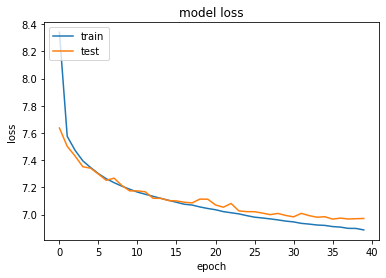

In [291]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 [==============================] - 1s 4ms/step


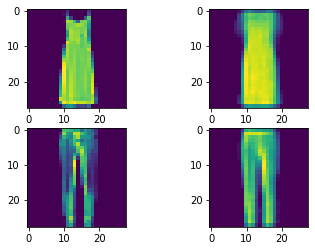

In [197]:
# index = int(input())
visualisasi_rekonstruksi(13)

In [198]:
keras.models.save_model(encoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_2_E40_Encoder.h5')
keras.models.save_model(decoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_2_E40_Decoder.h5')
keras.models.save_model(vae, '/content/drive/MyDrive/Variational Auto Encoder/Model_2_E40_VAE.h5')

1/1 [==============================] - 0s 123ms/step


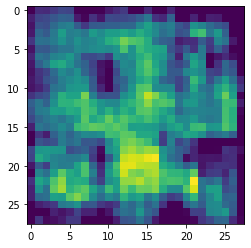

In [199]:
sample_vector = np.array([[90,24]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))

1875/1875 [==============================] - 4s 2ms/step
[[ -392.6643     157.08789 ]
 [-1329.8383   -1447.5986  ]
 [ -229.90262   -542.1952  ]
 ...
 [ -778.36163  -1218.4578  ]
 [ -633.3196    -505.93585 ]
 [ -106.724014   206.54028 ]]


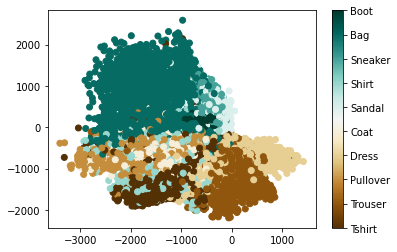

In [203]:
tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
labels = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
latent_dim=2

encoder = keras.models.load_model('/content/drive/MyDrive/Variational Auto Encoder/Model_2_E40_Encoder.h5', custom_objects={'latent_dim': latent_dim})
z = encoder.predict(X_train)
print(z)




fig = plt.scatter(z[:,0], z[:,1], c=y_train, cmap='BrBG')
cbar = plt.colorbar(fig)
cbar.set_ticks(list(range(0,10)))
cbar.set_ticklabels(labels)
plt.show()

In [204]:
z.shape

(60000, 2)

1/1 [==============================] - 0s 17ms/step


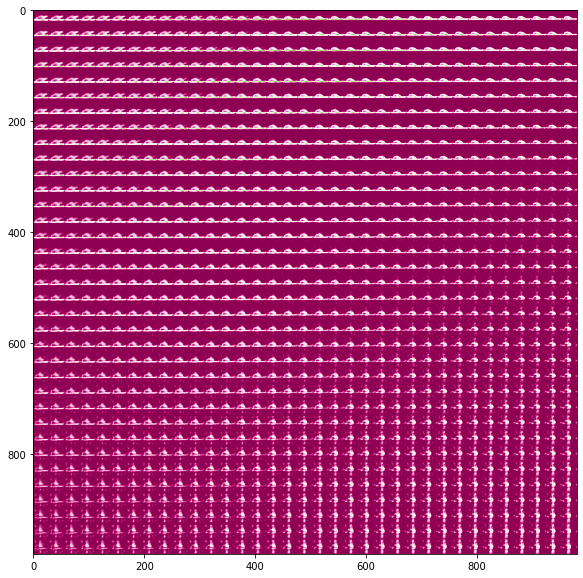

In [205]:
visualize_latent_space('/content/drive/MyDrive/Variational Auto Encoder/Model_2_E40_Decoder.h5', 35)

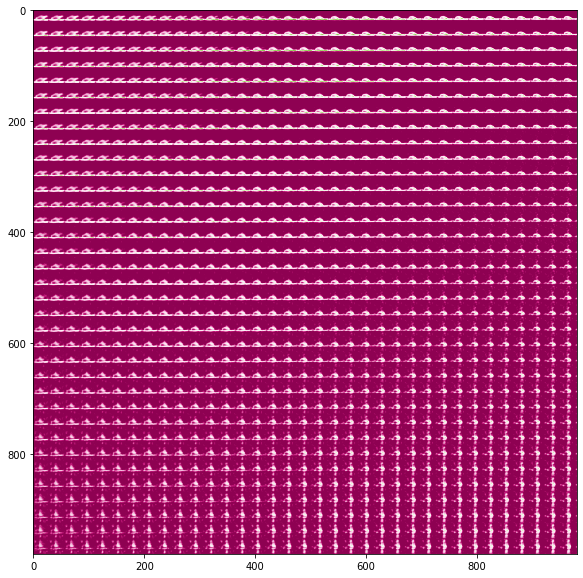

## Training 3 Dimensi Latent Space

### Encoder

In [274]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = K.int_shape(x)

In [275]:
x = Flatten()(x)
x = Dense(32)(x)

Laten Space

In [276]:
latent_dim = 3 #1D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

Fungsi di bawah ini akan  mengambil parameter mean dan log varians dan mengembalikan sampel acak dari distribusi yang dihasilkan.

In [277]:
def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps
  return rnd_sam

 kode di bawah ini merupakan layer untuk memperoleh nilai Latent Space (z) dengan menggunakan Lambda Expression. 

In [278]:
z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

### Model Summary

Dari Beberapa Fungsi di atas, Summary yang diperoleh, ditampilkan pada visualisasi di bawah ini

In [279]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 28, 28, 128)  3328        ['encoder input[0][0]']          
                                                                                                  
 conv2d_49 (Conv2D)             (None, 14, 14, 64)   73792       ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_50 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_49[0][0]']              
                                                                                            

### Decoder

pada bagian ini,  kita perlu mengambil vektor dari ruang laten 3D sampel acak dan mengubahnya kembali ke format asli gambar yaitu, 28x28 dengan *single channel*

In [280]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense_24 (Dense)            (None, 12544)             50176     
                                                                 
 reshape_11 (Reshape)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_57 (Conv2D  (None, 28, 28, 64)       3692

### Menghubungkan Semua Komponen

Menghubungkan Encoder, Latent Space dan Decoder 

In [281]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)

In [282]:
vae_3 = keras.Model(enc_input, dec_output, name='VAE_3')
vae_3.summary()

Model: "VAE_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 3)                 552614    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         369089    
                                                                 
Total params: 921,703
Trainable params: 921,703
Non-trainable params: 0
_________________________________________________________________


### Training Model 3 Epoch 20 

In [238]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae_3.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))
history_3 = vae_3.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
1875/1875 [==============================] - 26s 13ms/step - loss: 8.0025 - val_loss: 6.9927
Epoch 2/20
1875/1875 [==============================] - 24s 13ms/step - loss: 6.9125 - val_loss: 6.8513
Epoch 3/20
1875/1875 [==============================] - 25s 13ms/step - loss: 6.8103 - val_loss: 6.7829
Epoch 4/20
1875/1875 [==============================] - 24s 13ms/step - loss: 6.7476 - val_loss: 6.7144
Epoch 5/20
1875/1875 [==============================] - 25s 14ms/step - loss: 6.7013 - val_loss: 6.6866
Epoch 6/20
1875/1875 [==============================] - 26s 14ms/step - loss: 6.6645 - val_loss: 6.6531
Epoch 7/20
1875/1875 [==============================] - 24s 13ms/step - loss: 6.6334 - val_loss: 6.6294
Epoch 8/20
1875/1875 [==============================] - 25s 13ms/step - loss: 6.6108 - val_loss: 6.6186
Epoch 9/20
1875/1875 [==============================] - 25s 13ms/step - loss: 6.5893 - val_loss: 6.5894
Epoch 10/20
1875/1875 [==============================] - 24s 13m

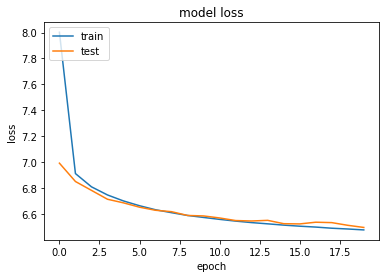

In [294]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

313/313 [==============================] - 2s 5ms/step


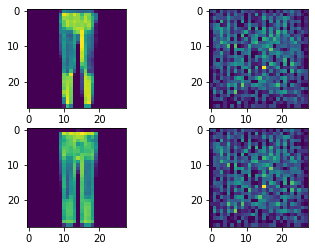

In [217]:
def visualisasi_rekonstruksi(index):
  y_pred = vae_3.predict(X_test)

  plt.figure(1)
  plt.subplot(221)
  plt.imshow(X_test[index].reshape(28,28))

  plt.subplot(222)
  plt.imshow(y_pred[index].reshape(28,28))

  plt.subplot(223)
  plt.imshow(X_test[index*5].reshape(28,28))

  plt.subplot(224)
  plt.imshow(y_pred[index*5].reshape(28,28))
  plt.show()

visualisasi_rekonstruksi(3)

In [218]:
keras.models.save_model(encoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_3_E20_Encoder.h5')
keras.models.save_model(decoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_3_E20_Decoder.h5')
keras.models.save_model(vae, '/content/drive/MyDrive/Variational Auto Encoder/Model_3_E20_VAE.h5')

1/1 [==============================] - 0s 27ms/step


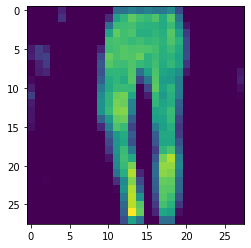

In [247]:
sample_vector = np.array([[5,20,20]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))

1875/1875 [==============================] - 4s 2ms/step
[[13.507876    9.355757   -4.5447445 ]
 [14.4905     13.590712    0.21396548]
 [-1.9576063   3.5509584   4.3433423 ]
 ...
 [-5.0257206  10.963257    2.1139123 ]
 [ 6.1631074   5.1514616  -1.1740909 ]
 [ 3.5631924   5.8405905  -2.6332161 ]]


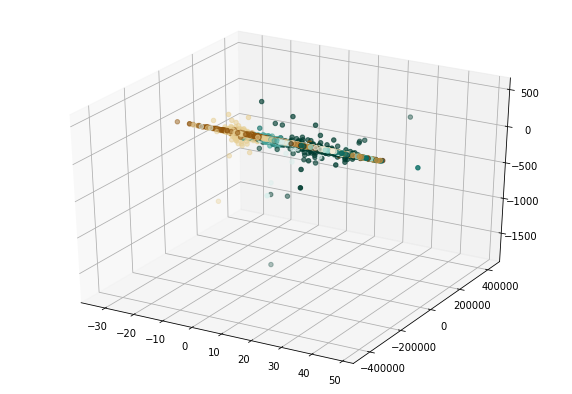

In [258]:
from mpl_toolkits import mplot3d

tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
labels = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
latent_dim=3

encoder = keras.models.load_model('/content/drive/MyDrive/Variational Auto Encoder/Model_3_E20_Encoder.h5', custom_objects={'latent_dim': latent_dim})
z = encoder.predict(X_train)
print(z)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# ax.scatter3D
ax.scatter3D(z[:,0], z[:,1],z[:,2], c=y_train, cmap='BrBG')
# fig = plt.scatter3D(z[:,0], z[:,1],z[:,2], c=y_train, cmap='BrBG')
# cbar = plt.colorbar(fig)
cbar.set_ticks(list(range(0,10)))
cbar.set_ticklabels(labels)
plt.show()

### Training Model 4 Epoch 40

In [283]:
vae_4 = keras.Model(enc_input, dec_output, name='VAE_4_E40')
vae_4.summary()

Model: "VAE_4_E40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 3)                 552614    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         369089    
                                                                 
Total params: 921,703
Trainable params: 921,703
Non-trainable params: 0
_________________________________________________________________


In [284]:
vae_4.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))
history_4 = vae_4.fit(X_train, X_train, epochs=40, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/40
1875/1875 [==============================] - 26s 13ms/step - loss: 7.8626 - val_loss: 7.0254
Epoch 2/40
1875/1875 [==============================] - 24s 13ms/step - loss: 6.9579 - val_loss: 6.9051
Epoch 3/40
1875/1875 [==============================] - 24s 13ms/step - loss: 6.8408 - val_loss: 6.8003
Epoch 4/40
1875/1875 [==============================] - 25s 13ms/step - loss: 6.7656 - val_loss: 6.7367
Epoch 5/40
1875/1875 [==============================] - 25s 13ms/step - loss: 6.7120 - val_loss: 6.6923
Epoch 6/40
1875/1875 [==============================] - 24s 13ms/step - loss: 6.6722 - val_loss: 6.6819
Epoch 7/40
1875/1875 [==============================] - 25s 13ms/step - loss: 6.6415 - val_loss: 6.6380
Epoch 8/40
1875/1875 [==============================] - 24s 13ms/step - loss: 6.6156 - val_loss: 6.6154
Epoch 9/40
1875/1875 [==============================] - 24s 13ms/step - loss: 6.5968 - val_loss: 6.6095
Epoch 10/40
1875/1875 [==============================] - 25s 13m

313/313 [==============================] - 2s 5ms/step


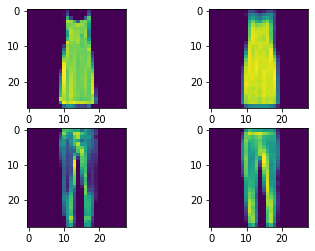

In [285]:
# index = int(input())
visualisasi_rekonstruksi(13)

In [286]:
keras.models.save_model(encoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_4_E40_Encoder.h5')
keras.models.save_model(decoder, '/content/drive/MyDrive/Variational Auto Encoder/Model_4_E40_Decoder.h5')
keras.models.save_model(vae, '/content/drive/MyDrive/Variational Auto Encoder/Model_4_E40_VAE.h5')

1/1 [==============================] - 0s 130ms/step


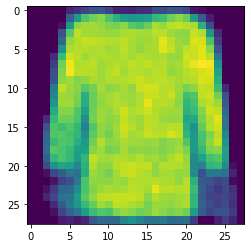

In [287]:
sample_vector = np.array([[90,24,1]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))

1875/1875 [==============================] - 5s 2ms/step
[[ -965.05646   1061.1818    5798.2246  ]
 [ 5535.243      860.187    -2942.0664  ]
 [ 1040.2119   -1926.8168     528.5441  ]
 ...
 [ 3419.5881   -3605.529      184.53777 ]
 [ 1834.2397     403.5656    -380.44418 ]
 [   16.183012   962.17346    547.96716 ]]


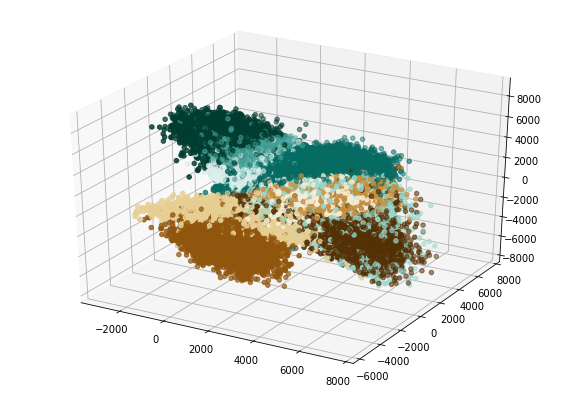

In [288]:
from mpl_toolkits import mplot3d

tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
labels = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
latent_dim=3

encoder = keras.models.load_model('/content/drive/MyDrive/Variational Auto Encoder/Model_4_E40_Encoder.h5', custom_objects={'latent_dim': latent_dim})
z = encoder.predict(X_train)
print(z)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# ax.scatter3D
ax.scatter3D(z[:,0], z[:,1],z[:,2], c=y_train, cmap='BrBG')
# fig = plt.scatter3D(z[:,0], z[:,1],z[:,2], c=y_train, cmap='BrBG')
# cbar = plt.colorbar(fig)
cbar.set_ticks(list(range(0,10)))
cbar.set_ticklabels(labels)
plt.show()

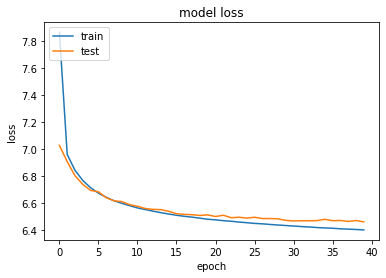

In [293]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()